## House Price Prediction

### This project is a Kaggle competition in which predictions are made on house prices in Ames, Iowa. The objective is to accurately predict the house prices in the test data set. To achieve this objective, both the training and test data sets must be cleaned. Then the training set is split to be modeled using an ensemble of regression algorithms, which then is used to predict on the test data set. 

#### To start the libraries are imported

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt  
%matplotlib inline

import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import LabelEncoder

from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore') 

/Users/DK/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### The training and test data sets are loaded

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### The Ids for both data sets are saved into variables and dropped from the data sets

In [3]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Data Exploration

#### Since regression will be used to make predictions, outliers could potentially throw off the accuracy of the model and it appears that there are outliers in the training set.

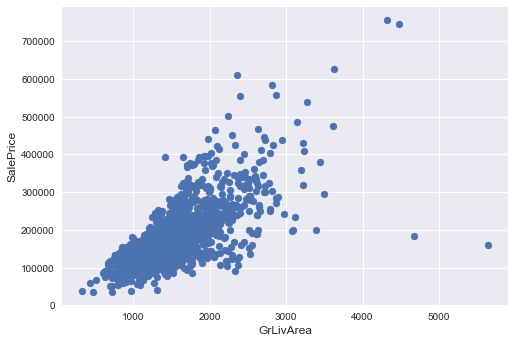

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('GrLivArea', fontsize=12)
plt.show()

#### It appears that there are 2 houses that have large living areas yet have a low sale price. So it is assumed that it is safe to delete them.

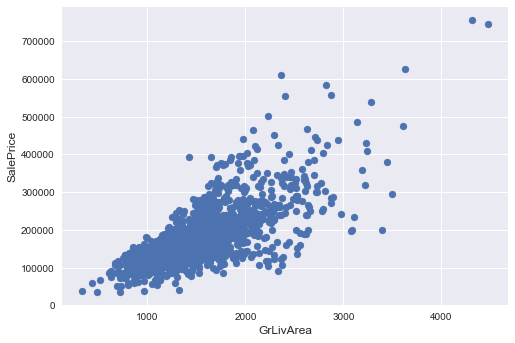

In [5]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('GrLivArea', fontsize=12)
plt.show()

#### Looking at the distribution of the values for sale price, it appears that the distribution is skewed left

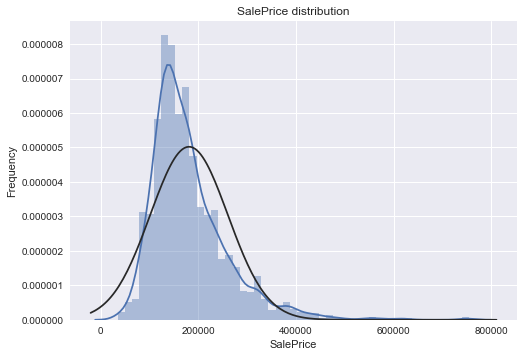

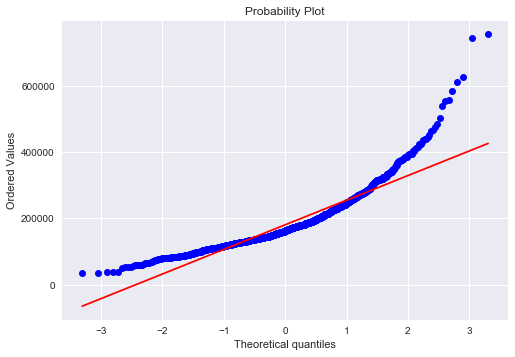

In [6]:
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### After performing a log transformation on the SalePrice column the distribution is normal 

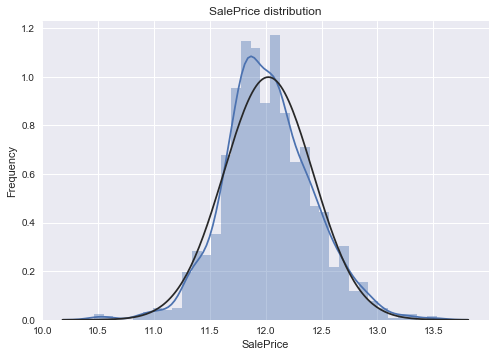

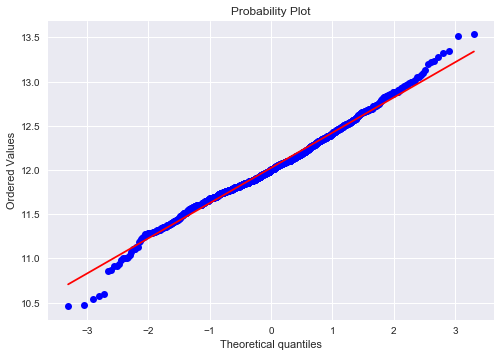

In [7]:
train["SalePrice"] = np.log(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### The testing set is concatenated to the training set so that the data can be cleaned of null values and inaccurate values

In [8]:
y_train = train.SalePrice.values
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

## Data Cleaning

#### Since there are so many columns and among them there are so many columns with null values, a data frame is created to see all the columns that have missing values.

In [9]:
null_data = (df.isnull().sum() / len(df)) * 100
null_data = null_data.drop(null_data[null_data == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :null_data})
missing_data

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


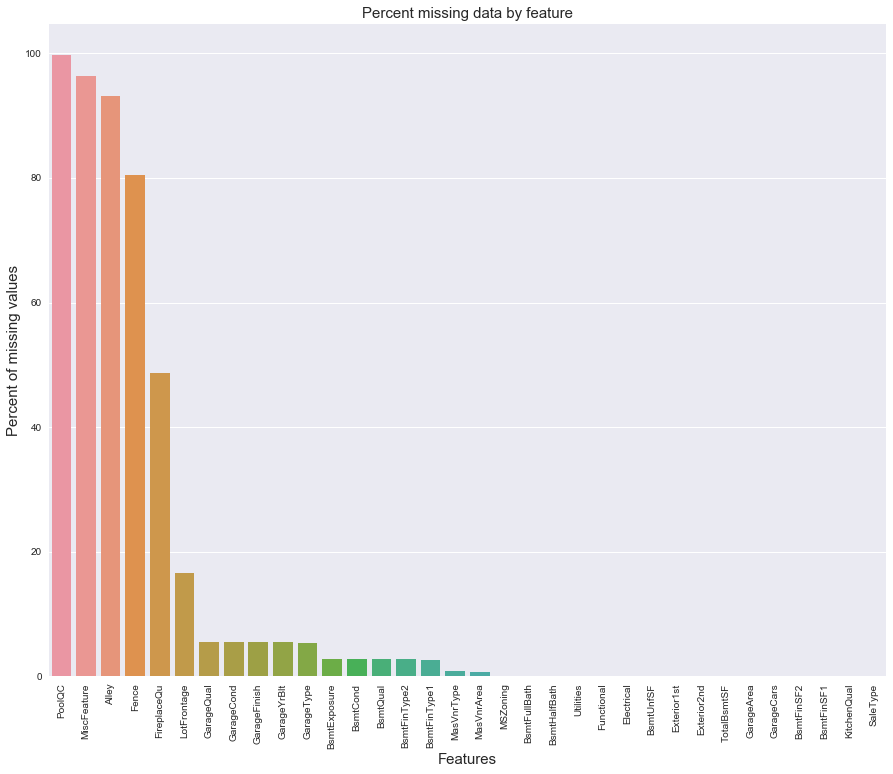

In [10]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=null_data.index, y=null_data);
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#### A correlation map is created to see which features have a high correlation with sale price

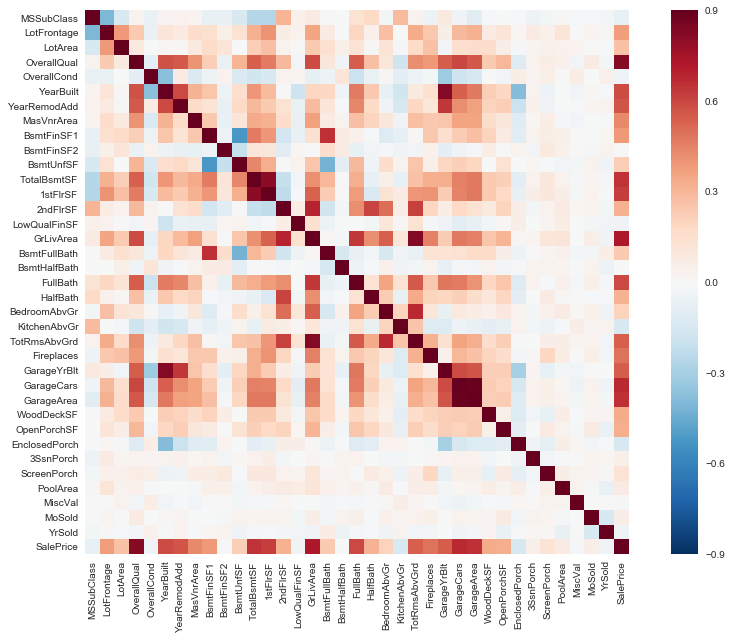

In [11]:
corrmat = train.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, vmax=0.9, square=True);

#### According to the data dictionary, it appears that some of the columns have NA values to indicate the lack of a certain feature, for example with PoolQC, NA indicates that the lack of a pool.

In [12]:
df["PoolQC"] = df["PoolQC"].fillna("NoPool")
df["MiscFeature"] = df["MiscFeature"].fillna("NoFeats")
df["Alley"] = df["Alley"].fillna("NoAlley")
df["Fence"] = df["Fence"].fillna("NoFence")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('NoBasement')

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)   
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('NoGarage')    
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)
    
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df['MSSubClass'] = df['MSSubClass'].fillna("None")

#### For LotFrontage the median value was used to replace the missing values

In [13]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#### For the rest of the missing values, the mode was used to replace the missing values

In [14]:
df['MSZoning'] = df['MSZoning'].fillna("Typ")
df["Functional"] = df["Functional"].fillna(df['Functional'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

#### It was determined that Utilities can be safely dropped since the training data consist of AllPub as the only value for this feature

In [15]:
df = df.drop(['Utilities'], axis=1)

#### The same data frame is created to check if there are any null values still

In [16]:
null_data = (df.isnull().sum() / len(df)) * 100
null_data = null_data.drop(null_data[null_data == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :null_data})
missing_data

,Missing Ratio


## Feature Engineering

#### Columns with numeric values are converted to string so that these columns can be considered categorical and become dummy variables

In [17]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

#### Label Encoding is done on the categorical variables so that the values become ordinal variables

In [18]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[col].values)) 
    df[col] = lbl.transform(list(df[col].values))
  

In [19]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#### It appears that among the features that are not categorical, there is a skewed distribution

In [20]:
noncate_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[noncate_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew': skewed_feats})
skewness

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


#### Therefore the values are transformed using Box Cox Transformation to normalize the highly skewed values

In [21]:
skewness = skewness[abs(skewness) > 0.75]
print "There are", skewness.shape[0], "skewed numerical features to Box Cox transform"

skewed_features = skewness.index
lmbda = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lmbda)
    df[feat] += 1

There are 59 skewed numerical features to Box Cox transform


## Modeling

#### Now that the features have been extracted and normalized, it is time to make predictions 

In [22]:
df = pd.get_dummies(df)

In [23]:
train_df = df[:len(train)]
test_df = df[len(train):]

#### The data set will be split using KFold and Cross Validation. 

In [24]:
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse= np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Since an ensemble of algorithms will be used to make the final prediction on the test set, a pipeline is used to incorporate the Robust Scaler, which handles outliers that may have not been handled.

In [25]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
print "RMSE for lasso:", rmsle_cv(lasso).mean()

RMSE for lasso: 0.13895773157


In [26]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
print "RMSE for elastic net:", rmsle_cv(ENet).mean()

RMSE for elastic net: 0.138746019119


In [27]:
KR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
print "RMSE for Kernel Ridge:", rmsle_cv(KR).mean()

RMSE for Kernel Ridge: 0.14644668898


In [28]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
print "RMSE for Gradient Boosting:", rmsle_cv(GB).mean()

RMSE for Gradient Boosting: 0.179831933213


In [29]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2,seed=42, silent=1)
print "RMSE for XGB:", rmsle_cv(model_xgb).mean()

RMSE for XGB: 0.20494889896


#### A class is created to take the models and average their predictions

In [30]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

In [31]:
averaged_models = AveragingModels(models = (ENet, GB, KR, lasso))
score = rmsle_cv(averaged_models)

print "Average base model score:", score.mean()

Average base model score: 0.145157536158


In [32]:
averaged_models.fit(train_df.values, y_train)
train_pred = averaged_models.predict(train_df.values)
pred = averaged_models.predict(test_df.values)
np.sqrt(mean_squared_error(y_train, train_pred))

0.079455982385721713

In [33]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = model_xgb.predict(test_df)
np.sqrt(mean_squared_error(y_train, xgb_train_pred))

0.042031749685174299

In [34]:
print 'RMSE score on train data:', np.sqrt(mean_squared_error(y_train,train_pred*0.70 + xgb_train_pred*0.30 ))

RMSE score on train data: 0.0664286047546


In [35]:
ensemble = pred*0.70 + xgb_pred*0.30 

In [36]:
results = pd.DataFrame()
results['Id'] = test_ID
results['SalePrice'] = ensemble
results.to_csv('ensemble_output.csv')